## Exercise 2.1. <br>
Suppose there are two actions, $A_1$ and $A_2$, $Q_t(A_1) > Q_t(A_2)$.
Then $$\mathbb{P}(A_t = A_1) = (1 - \epsilon) + \epsilon*0.5 = 0.5 + 0.5*0.5 = 0.75$$
The second summand is due to the uniform distribution over actions.

## Exercise 2.2. <br>
On the first step, it could have been $\epsilon$-greedy action if we had $\epsilon$-greedy first selection rule (i.e., choose first action to be $A$ with probability $1 - \epsilon$, otherwise pick randomly). If the first action rule is completely deterministic, then we simply pick a specific action. On the second time step, exploration step definitely occurred because $Q_1(1) > Q_1(a) \ \forall a \neq 1$, so greedy step would have picked action 1. On the third step, exploration step could have occurred, but so could have exploitation step. The fourth step could have been either explorative or exploitative. The fifth step was definitely explorative because $Q_5(2) > Q_5(a) \ \forall a \neq 2$, so greedy step would have picked action 2. 

In [46]:
#replication of Figure 2.2 from the book 
#import required libraries
import random as rd
import math
#define the bandit class
class Bandit:
    
    def __init__(self, k = 10):
        self.k = k #constructor for the class takes the number of bandit arms
        #set the q value
        self.q = [rd.gauss(0,1) for i in range(k)]
        #the optimal action is the one with objectively best value
        self.optimum = self.q.index(max(self.q))
        
    #a function to generate a one full run of a Bandit
    
    def run(self, runs = 1000, epsilon = 0.1, initial = 0, type_al = "average", alpha = 0.1, variance = 1):
        #this stores running percentage of optimal action visits
        optimal_actions_pct = [0]*runs
        #this stores average rewards for each step
        average_rewards = [0]*runs
        #this stores average rewards for each action: Q(a)/n where Q(a) is the sum of rewards
        #for action a, and n is the number of times action a was used (visited)
        action_rewards = [initial]*self.k
        #this we need to store the number of times action was used
        action_counts = [0]*self.k
        #this we need to count number of times optimal action is visited
        opt_actions = 0
        #run the simulation
        for run in range(runs):
            eps = rd.random() #draw epsilon from the uniform distribution
            if eps<epsilon:
                action = rd.choice(range(self.k)) #exploration step
            else:
                action = action_rewards.index(max(action_rewards)) #exploitation step
            opt_actions += (action==self.optimum) 
            optimal_actions_pct[run] = (opt_actions)/(1.00*(run + 1))
            reward = rd.gauss(self.q[action], variance)
            if type_al == "average":
                action_counts[action] += 1
                action_rewards[action] = (action_rewards[action]*(action_counts[action] - 1) 
                                         + reward)/action_counts[action]
            else:
                action_rewards[action] = action_rewards[action] + alpha*(reward - action_rewards[action])
            average_rewards[run] = (average_rewards[run-1]*(run)*(run>0) + reward)/(run + 1)
        return(optimal_actions_pct, average_rewards)
    
    #ucb algorithm
    
    def maximizer(self, rewards, counts, c, t):
        max_val = float("-inf")
        for x in range(len(rewards)):
            if counts[x] == 0:
                return x
            if max_val <= rewards[x] + c*(math.log(t)/counts[x])**0.5:
                max_val = rewards[x] + c*(math.log(t)/counts[x])**0.5
                action = x
        return action
    
    def run_ucb(self, runs = 1000, c = 2, initial = 0, type_al = "average", alpha = 0.1, variance = 1):
        #this stores running percentage of optimal action visits
        optimal_actions_pct = [0]*runs
        #this stores average rewards for each step
        average_rewards = [0]*runs
        #this stores average rewards for each action: Q(a)/n where Q(a) is the sum of rewards
        #for action a, and n is the number of times action a was used (visited)
        action_rewards = [initial]*self.k
        #this we need to store the number of times action was used
        action_counts = [0]*self.k
        #this we need to count number of times optimal action is visited
        opt_actions = 0
        #run the simulation
        for run in range(runs):
            action = self.maximizer(action_rewards, action_counts, c, run)
            opt_actions += (action==self.optimum) 
            optimal_actions_pct[run] = (opt_actions)/(1.00*(run + 1))
            reward = rd.gauss(self.q[action], variance)
            if type_al == "average":
                action_counts[action] += 1
                action_rewards[action] = (action_rewards[action]*(action_counts[action] - 1) 
                                         + reward)/action_counts[action]
            else:
                action_rewards[action] = action_rewards[action] + alpha*(reward - action_rewards[action])
            average_rewards[run] = (average_rewards[run-1]*(run)*(run>0) + reward)/(run + 1)
        return(optimal_actions_pct, average_rewards)

In [2]:
epsilon_01_avr = [0]*1000
epsilon_001_avr = [0]*1000
epsilon_greedy_avr = [0]*1000

epsilon_01_opt = [0]*1000
epsilon_001_opt = [0]*1000
epsilon_greedy_opt = [0]*1000

for x in range(2000):
    new_bandit = Bandit()
    output_01 = new_bandit.run()
    output_001 = new_bandit.run(epsilon = 0.01)
    output_greedy = new_bandit.run(epsilon = 0)
    for y in range(1000):
        epsilon_01_avr[y] += output_01[1][y]/2000
        epsilon_001_avr[y] += output_001[1][y]/2000
        epsilon_greedy_avr[y] += output_greedy[1][y]/2000

        epsilon_01_opt[y] += output_01[0][y]/2000
        epsilon_001_opt[y] += output_001[0][y]/2000
        epsilon_greedy_opt[y] += output_greedy[0][y]/2000

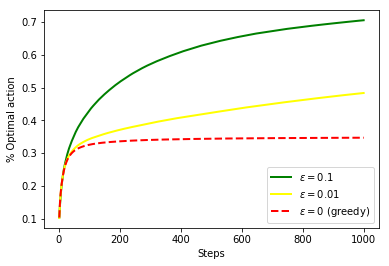

In [3]:
#generate plots
#this plot illustrates how often the optimal state is visited as the number of iterations increases
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
rewards_data = pd.DataFrame({'x': range(1, 1001), 'e_01': epsilon_01_opt, 
                             'e_001': epsilon_001_opt, 'greedy': epsilon_greedy_opt})
plt.plot( 'x', 'e_01', data=rewards_data, marker='', color='green', linewidth=2)
plt.plot( 'x', 'e_001', data=rewards_data, marker='', color='yellow', linewidth=2)
plt.plot( 'x', 'greedy', data=rewards_data, marker='', color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend(['$\epsilon = 0.1$', '$\epsilon = 0.01$', '$\epsilon = 0$ (greedy)'])

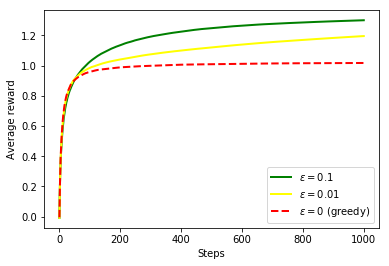

In [4]:
#generate plots
#this plot illustrates the average rewards
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
rewards_data = pd.DataFrame({'x': range(1, 1001), 'e_01': epsilon_01_avr, 
                             'e_001': epsilon_001_avr, 'greedy': epsilon_greedy_avr})
plt.plot( 'x', 'e_01', data=rewards_data, marker='', color='green', linewidth=2)
plt.plot( 'x', 'e_001', data=rewards_data, marker='', color='yellow', linewidth=2)
plt.plot( 'x', 'greedy', data=rewards_data, marker='', color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend(['$\epsilon = 0.1$', '$\epsilon = 0.01$', '$\epsilon = 0$ (greedy)'])

What is the theory behind $\epsilon$-greedy bandit model? <br>
Define a random variable $Q(a)$ to be the sum of rewards for action $a$ divided by the number of times this action is visited. Rewards are, in turn, independent and identically distributed since whenever action $a$ is visited reward is drawn from a Gaussian distribution with $\mu = q^*(a)$ and $\sigma^2 = 1$. To utilize strong law of large numbers (SLLN), we only need the algorithm to visit every $a$ infinite number of times, and $\epsilon$-greedy exploration steps guarantee that. Therefore, since each $a \in A$ is visited infinitely many times, by SLLN we have $Q(a) \to q^*(a)$ almost surely. <br>
Asymptotic consistency of $\epsilon$-greedy algorithm is a nice property, but it says nothing about the actual speed of convergence. Intuitively, when action space is large and $\epsilon$ is small, algorithm may take a very long time to converge. 

## Exercise 2.3. <br>
Let's write the expected value of reward: $$\mathbb{E}(R) = \epsilon[\sum_{j = 1}^{K}\frac{1}{K}q^*(a_j)] + (1 - \epsilon)q^*(a_i)$$ where $a_i$ is the best action available, and $K$ is the total number of actions. Now, $q^*(a_i) \geq \sum_{j = 1}^{K}\frac{1}{K}q^*(a_j)$, implying that in the long run algorithms with smaller exploration steps will perform better or at least not worse. The actual improvement can be expressed as follows. Suppose $\epsilon_1 \geq \epsilon_2$. Then $\mathbb{E}_{\epsilon_2}(R) - \mathbb{E}_{\epsilon_1}(R) = (\epsilon_2 - \epsilon_1)*[(\sum_{j = 1}^{K}\frac{1}{K}*q^*(a_j)] + (\epsilon_1 - \epsilon_2)*q^*(a_i)$.

## Proof of the weighted average on page 25 <br>
We need to prove that $(1 - \alpha)^n + \sum_{i=1}^{n}\alpha*(1-\alpha)^{n-i} = 1$. Consider the case $n=1$. Then we have $(1 - \alpha) + \alpha = 1$, establishing the baseline case for induction. Suppose statement holds for $n$. Then $(1 - \alpha)^{n+1} + \sum_{i=1}^{n}\alpha*(1-\alpha)^{n+1-i} = 1 - \alpha \implies (1 - \alpha)^{n+1} + \sum_{i=1}^{n+1}\alpha*(1-\alpha)^{n+1-i} = 1 - \alpha + \alpha*(1-\alpha)^{n+1-n-1} = 1$

## Convergence of $\epsilon$-greedy algorithm for non-stationary rewards with $\alpha = 1/n$. <br>
For non-stationary problem, simple SLLN does not apply since rewards for actions are no longer i.i.d. Nonetheless, rewards for actions are still __independent__, so one can apply a version of SLLN referred as Kolmogorov SLLN. This version requires that each reward for a specific action is drawn from a distribution with finite second moment, and $\sum_{i=1}^{\infty}\frac{1}{k^2}Var[X_k] < \infty$. Not all distributions, of course, will satisfy these conditions, but the Normal distribution does. Finiteness of the second moment follows from standard properties of the Normal distribution. To prove the second requirement, denote $\theta = \max_{k} (Var[X_k]) < \infty$ (by the finiteness of variance of the Normal distribution). We have $\sum_{i=1}^{\infty}\frac{1}{k^2}Var[X_k] \leq \theta*\sum_{i=1}^{\infty}\frac{1}{k^2} = \theta*\frac{\pi^2}{6} < \infty$. Regarding the general applicability of these conditions, it suffices to say that most distributions of practical importance satisfy them. Robbins-Monro conditions (see page 26) are more general and allow for other sequences that lead to asymptotically consistent estimates of action values. One can check that $1/n$ sequence indeed satisfies Robbins-Monro conditions. 

## Exercise 2.5 <br>
Experiments below illustrate that asympotically consistent algorithms can demonstrate inferior performance in practice, at least when the problem is non-stationary. Selection of $\alpha$, therefore, should be informed by both theoretical (Robbins-Monro conditions) and practical considerations. 

In [5]:
class Bandit_nonstat:
    
    def __init__(self, k = 10):
        self.k = k #constructor for the class takes the number of bandit arms
        #set the q value
        all_vals = rd.gauss(0,1)
        self.q = [all_vals for i in range(k)]
        
    
    #run non-stationary bandit
    
    def run(self, runs = 1000, epsilon = 0.1, alpha = 0.1):
        #this stores running percentage of optimal action visits
        optimal_actions_pct_alpha = [0]*runs
        optimal_actions_pct_n = [0]*runs
        #this stores average rewards for each step
        average_rewards_alpha = [0]*runs
        average_rewards_n = [0]*runs
        #this stores average rewards for each action: Q(a)/n where Q(a) is the sum of rewards
        #for action a, and n is the number of times action a was used (visited)
        action_rewards_n = [0]*self.k
        #this stores rewards for alpha algorithm
        action_rewards_alpha = [0]*self.k        
        #this we need to store the number of times action was used - only for sample average
        #algorithm
        action_counts = [0]*self.k
        #this we need to count the number of times optimal action is visited
        opt_actions_n = 0
        opt_actions_alpha = 0
        #run the simulation
        for run in range(runs):
            #update self.q - done in the beginning of the loop to get better looking graph
            self.q = [i + rd.gauss(0, 0.01) for i in self.q]
            eps = rd.random() #draw epsilon from the uniform distribution
            if eps<epsilon:
                action_alpha = action_n = rd.choice(range(self.k)) #exploration step
            else:
                action_alpha = action_rewards_alpha.index(max(action_rewards_alpha)) #exploitation step
                action_n = action_rewards_n.index(max(action_rewards_n))
            optimal = self.q.index(max(self.q))
            opt_actions_alpha += (action_alpha==optimal)
            opt_actions_n += (action_n==optimal)
            optimal_actions_pct_alpha[run] = (opt_actions_alpha)/(1.00*(run + 1))
            optimal_actions_pct_n[run] = (opt_actions_n)/(1.00*(run + 1))
            reward_alpha = rd.gauss(self.q[action_alpha], 1)
            reward_n = rd.gauss(self.q[action_n], 1)
            action_counts[action_n] += 1
            action_rewards_alpha[action_alpha] = action_rewards_alpha[action_alpha] + alpha*(reward_alpha - action_rewards_alpha[action_alpha])
 
            action_rewards_n[action_n] = (action_rewards_n[action_n]*(action_counts[action_n] - 1)+ reward_n)/action_counts[action_n]            
            average_rewards_alpha[run] = (average_rewards_alpha[run-1]*(run)*(run>0) + reward_alpha)/(run + 1)
            average_rewards_n[run] = (average_rewards_n[run-1]*(run)*(run>0) + reward_n)/(run + 1)
        return(optimal_actions_pct_alpha, optimal_actions_pct_n, 
               average_rewards_alpha, average_rewards_n)    

In [6]:
#run the simulation
n_avr = [0]*10000
constant_avr = [0]*10000

n_opt = [0]*10000
constant_opt = [0]*10000


for x in range(2000):
    new_bandit = Bandit_nonstat()
    output = new_bandit.run(runs = 10000)
    for y in range(10000):
        n_avr[y] += output[3][y]/2000
        constant_avr[y] += output[2][y]/2000
        n_opt[y] += output[1][y]/2000
        constant_opt[y] += output[0][y]/2000
    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


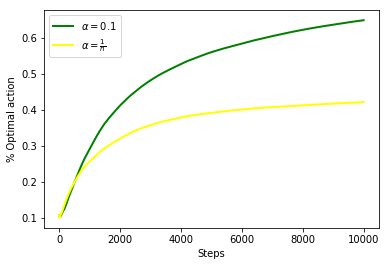

In [7]:
#generate plots
#this plot illustrates how often the optimal state is visited as the number of iterations increases
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
rewards_data = pd.DataFrame({'x': range(1, 10001), 'alpha': constant_opt, 
                             'n': n_opt})
plt.plot( 'x', 'alpha', data=rewards_data, marker='', color='green', linewidth=2)
plt.plot( 'x', 'n', data=rewards_data, marker='', color='yellow', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend([r'$\alpha = 0.1$', r'$\alpha = \frac{1}{n}$'])

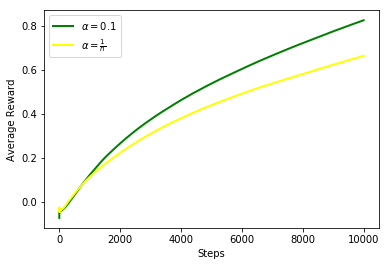

In [8]:
#generate plots
#this plot illustrates the average rewards
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
rewards_data = pd.DataFrame({'x': range(1, 10001), 'alpha': constant_avr, 
                             'n': n_avr})
plt.plot( 'x', 'alpha', data=rewards_data, marker='', color='green', linewidth=2)
plt.plot( 'x', 'n', data=rewards_data, marker='', color='yellow', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend([r'$\alpha = 0.1$', r'$\alpha = \frac{1}{n}$'])

In [23]:
#replicating figure 2.3 from the book
epsilon = [0]*1000
greedy = [0]*1000

for x in range(2000):
    new_bandit = Bandit()
    output_epsilon = new_bandit.run(type_al = "alpha")
    output_greedy = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha")
    for y in range(1000):
        epsilon[y] += output_epsilon[0][y]/2000
        greedy[y] += output_greedy[0][y]/2000

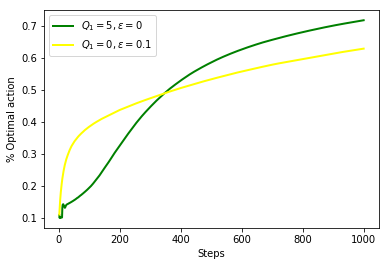

In [24]:
#replicate figure 2.3
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
rewards_data = pd.DataFrame({'x': range(1, 1001), 'epsilon': epsilon, 
                             'greedy': greedy})
plt.plot( 'x', 'greedy', data=rewards_data, marker='', color='green', linewidth=2)
plt.plot( 'x', 'epsilon', data=rewards_data, marker='', color='yellow', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend([r'$Q_1 = 5, \epsilon = 0$', r'$Q_1 = 0, \epsilon = 0.1$'])

## Exercise 2.4 <br>
$Q_{n+1} = Q_n + \alpha_n(R_n - Q_n) = \alpha_nR_n + Q_n(1 - \alpha_n) = \alpha_nR_n + (1 - \alpha_n)(\alpha_{n-1}R_{n - 1} + (1 - \alpha_{n-1})Q_{n-1}) = \alpha_nR_n + (1 - \alpha_n)\alpha_{n-1}R_{n - 1} + (1 - \alpha_n)(1 - \alpha_{n-1})Q_{n-1} = ... = Q_1\prod_{i=1}^{n}(1 - \alpha_i) + \sum_{i=1}^{n}R_i\alpha_{i}\prod_{j=i+1}^{n}(1 - \alpha_j)$

## Exercise 2.6 <br>
The update rule us $Q_{n+1}(a) = Q_n(a) + \alpha(R_n - Q_n(a))$. Since initial values of $Q_1(a)$ are all optimistic, all rewards are initially updated in the negative direction. As a result, optimistic initial values allow to explore all 10 actions on the first 10 steps. After this is done, it is highly likely that the best action received the best evaluation, and is, therefore, selected (hence, the jump on 11th step). However, since rewards are drawn from the Standard Normal Distribution, this best action is almost guaranteed to get a negative update once again, leading to selection of another action at the next step. More steps lead to better evaluations and, therefore, more frequent selection of the best one. <br>
Oscillations can be increased by lowering $\alpha$. See the figure below, for example. This is due to the fact that the action-values are closer to each other (lower $\alpha$ implies slower rate of updating), and sub-optimal action is, therefore, more likely to be picked. <br>

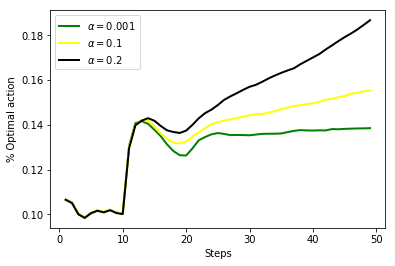

In [32]:
#first 50 steps are shown to magnify oscillations
greedy_001 = [0]*1000
greedy_01 = [0]*1000
greedy_02 = [0]*1000

for x in range(2000):
    new_bandit = Bandit()
    output_001 = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha", alpha = 0.001)
    output_01 = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha", alpha = 0.1)
    output_02 = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha", alpha = 0.2)
    for y in range(1000):
        greedy_001[y] += output_001[0][y]/2000
        greedy_01[y] += output_01[0][y]/2000
        greedy_02[y] += output_02[0][y]/2000
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
rewards_data = pd.DataFrame({'x': range(1, 50), 'greedy001': greedy_001[0:49], 
                             'greedy01': greedy_01[0:49], 'greedy02': greedy_02[0:49]})
plt.plot( 'x', 'greedy001', data=rewards_data, marker='', color='green', linewidth=2)
plt.plot( 'x', 'greedy01', data=rewards_data, marker='', color='yellow', linewidth=2)
plt.plot( 'x', 'greedy02', data=rewards_data, marker='', color='black', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend([r'$\alpha = 0.001$', r'$\alpha = 0.1$', r'$\alpha = 0.2$'])

Jumping step is, of course, determined by the number of bandit's "arms": with many arms, algorithm will perform worse for as many steps as there are "arms" because every single action gets sequentially explored. <br>
Another important parameter is the variance of reward distributions. Oscillations are expected to be smaller on average when the variance is bigger. See the figure below for illustration. 

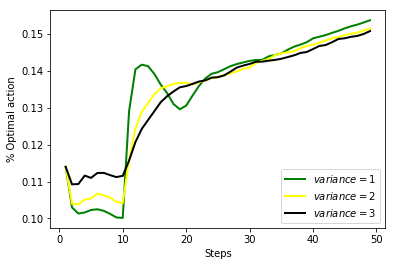

In [36]:
#first 50 steps are shown to magnify oscillations
greedy_1 = [0]*1000
greedy_2 = [0]*1000
greedy_3 = [0]*1000

for x in range(2000):
    new_bandit = Bandit()
    output_1 = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha")
    output_2 = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha", variance = 2)
    output_3 = new_bandit.run(epsilon = 0, initial = 5, type_al = "alpha", variance = 3)
    for y in range(1000):
        greedy_1[y] += output_1[0][y]/2000
        greedy_2[y] += output_2[0][y]/2000
        greedy_3[y] += output_3[0][y]/2000
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
rewards_data = pd.DataFrame({'x': range(1, 50), 'greedy1': greedy_1[0:49], 
                             'greedy2': greedy_2[0:49], 'greedy3': greedy_3[0:49]})
plt.plot( 'x', 'greedy1', data=rewards_data, marker='', color='green', linewidth=2)
plt.plot( 'x', 'greedy2', data=rewards_data, marker='', color='yellow', linewidth=2)
plt.plot( 'x', 'greedy3', data=rewards_data, marker='', color='black', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend([r'$variance = 1$', r'$variance = 2$', r'$variance = 3$'])

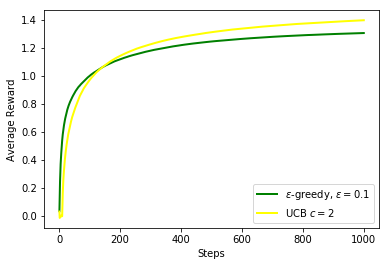

In [47]:
#replicates figure 2.4
eps = [0]*1000
ucb = [0]*1000

for x in range(2000):
    new_bandit = Bandit()
    output_eps = new_bandit.run(type_al = "average")
    output_ucb = new_bandit.run_ucb(type_al = "average")
    for y in range(1000):
        eps[y] += output_eps[1][y]/2000
        ucb[y] += output_ucb[1][y]/2000
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
rewards_data = pd.DataFrame({'x': range(1, 1001), 'eps': eps, 
                             'ucb': ucb})
plt.plot( 'x', 'eps', data=rewards_data, marker='', color='green', linewidth=2)
plt.plot( 'x', 'ucb', data=rewards_data, marker='', color='yellow', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend([r'$\epsilon$-greedy, $\epsilon=0.1$', r'UCB $c=2$'])